# Mapping Peak Annual Gage Height/Flow - Carnation
## Load from USGS
Source:
https://nwis.waterdata.usgs.gov/wa/nwis/peak?site_no=12149000&agency_cd=USGS&format=rdb

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

url = 'https://nwis.waterdata.usgs.gov/wa/nwis/peak?site_no=12149000&agency_cd=USGS&format=rdb'
df0 = pd.read_csv(url,comment='#',delimiter='\t')
df0 = df0.drop(0) # drop data type row
df0.head(5)

,agency_cd,site_no,peak_dt,peak_tm,peak_va,peak_cd,gage_ht,gage_ht_cd,year_last_pk,ag_dt,ag_tm,ag_gage_ht,ag_gage_ht_cd
1,USGS,12149000,1929-12-14,NaN,14800,NaN,7.62,3,NaN,NaN,NaN,NaN,NaN
2,USGS,12149000,1931-01-28,NaN,27400,NaN,10.51,3,NaN,NaN,NaN,NaN,NaN
3,USGS,12149000,1932-02-27,NaN,59500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USGS,12149000,1932-11-13,NaN,59000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,USGS,12149000,1933-11-03,NaN,48700,NaN,15.83,3,NaN,NaN,NaN,NaN,NaN


## Fix Up Data

In [2]:
# Calculate water year
df0['peak_dt'] = pd.to_datetime(df0['peak_dt'])
df0['water_year']=(df0['peak_dt'] + timedelta(days=92)).apply(lambda x: int(x.year))

# fix up datatypes
df0['gage_ht'] = df0['gage_ht'].apply(pd.to_numeric)
df0['peak_va'] = df0['peak_va'].apply(pd.to_numeric)

# Remove first 10 rows for Carnation. Gage hight changes to modern scale in 1940.
df = df0.loc[:,['water_year','peak_va','gage_ht']]
df.head(5)

,water_year,peak_va,gage_ht
1,1930,14800,7.62
2,1931,27400,10.51
3,1932,59500,NaN
4,1933,59000,NaN
5,1934,48700,15.83


## Add in 2022 

In [3]:
from datetime import date
df_2022 = pd.DataFrame([[2022,46900.0,58.73]], 
                       columns=['water_year','peak_va','gage_ht'])
df = df.append(df_2022, ignore_index=True)
df.tail(5)

/var/folders/7d/mngrr_516hd2614y74lctr_80000gn/T/ipykernel_12145/1627136759.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_2022, ignore_index=True)


,water_year,peak_va,gage_ht
88,2018,27800.0,56.08
89,2019,20100.0,53.91
90,2020,49200.0,58.72
91,2021,25200.0,55.26
92,2022,46900.0,58.73


## Mann_Kendall
From source: https://mail.scipy.org/pipermail/scipy-dev/2016-July/021413.html

>This function is derived from code originally posted by Sat Kumar Tomer (satkumartomer at gmail.com)
See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm

>The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert 1987) is to statistically 
assess if there is a monotonic upward or downward trend of the variable of interest over time. A 
monotonic upward (downward) trend means that the variable consistently increases (decreases) through 
time, but the trend may or may not be linear. The MK test can be used in place of a parametric linear 
regression analysis, which can be used to test if the slope of the estimated linear regression line 
is different from zero. The regression analysis requires that the residuals from the fitted regression 
line be normally distributed; an assumption not required by the MK test, that is, the MK test is a 
non-parametric (distribution-free) test.

>Hirsch, Slack and Smith (1982, page 107) indicate that the MK test is best viewed as an exploratory 
analysis and is most appropriately used to identify stations where changes are significant or of large 
magnitude and to quantify these findings.


In [4]:
from scipy import stats
from scipy.stats import norm

def mk_test(x, alpha = 0.05):
    """
    Input:
        x:   a vector of data
        alpha: significance level (0.05 default)

    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics

    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05)
    """
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)

    # calculate the var(s)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
            z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

## Plot function

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

from pylab import rcParams
rcParams['figure.figsize'] = 10,5

def plot_data(x_data, y_data, x_label, y_label, point_label):
    plt.scatter(x_data,y_data,
                color='blue', marker='o', label=point_label)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data,y_data)

    def func(x, a, b):
        return a*x + b

    plt.plot(x_data, func(x_data, slope, intercept), 'r-', label='fit',color='green')

    plt.legend(loc='upper left')

    plt.show()

    over_10_years = round(slope*10,2);
    print('slope  ',slope, ' (', over_10_years, ' every 10 years)', sep="")
    print('p_value ', p_value)
    print('r_value ', r_value)
    print('std_err ', std_err)


    critical_value = 1.664 #http://stattrek.com/regression/slope-confidence-interval.aspx?Tutorial=AP
    conf_interval = critical_value * std_err
    conf_over_10_years = round(conf_interval*10,2)
    print('conv_interval ', conf_interval, ' (+/-',conf_over_10_years,' over 10 years - 90% conf, ',
          over_10_years - conf_over_10_years, ' - ', 
          over_10_years + conf_over_10_years, ')', sep="")
    #    Mann-Kendall Output:
    #        trend: tells the trend (increasing, decreasing or no trend)
    #        h: True (if trend is present) or False (if trend is absence)
    #        p: p value of the significance test
    #        z: normalized test statistics
    def display_mk_test(data, alpha):
        mk = mk_test(data,alpha)
        print('Mann-Kendall test: ', int(100*(1-alpha)),'%', sep='')
        print('  slope:', mk[0])
        print('      h:', 'Monotonic trend is present' if mk[1] else 'No monottonic trend')
        print('      p:', mk[2])
        print('      z:', mk[3])
        return mk
    s,h,p,z = display_mk_test(y_data.values,0.1)
    if h: s,h,p,z = display_mk_test(y_data.values,0.05)
    if h: s,h,p,z = display_mk_test(y_data.values,0.01)

## Plots
Scatter plot of water_year and gage measures with least-squares linear regression fit line. 
### Max Gage Height 
From 1940, the first year the gage height was set to the current datum (1929 NGVD), through 2016.

/var/folders/7d/mngrr_516hd2614y74lctr_80000gn/T/ipykernel_12145/305832758.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_data, func(x_data, slope, intercept), 'r-', label='fit',color='green')


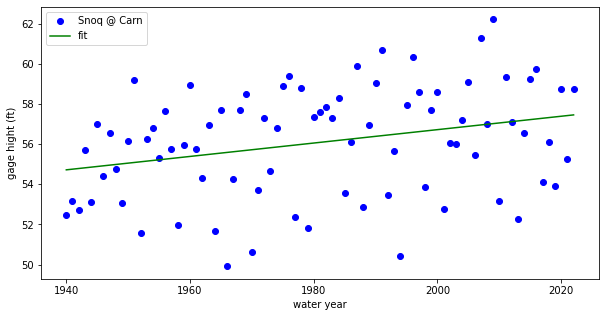

slope  0.033347676419965555 (0.33 every 10 years)
p_value  0.007005084001470711
r_value  0.2938810084374688
std_err  0.012051404490121525
conv_interval 0.020053537071562218 (+/-0.2 over 10 years - 90% conf, 0.13 - 0.53)
Mann-Kendall test: 90%
  slope: increasing
      h: Monotonic trend is present
      p: 0.0065788792178811395
      z: 2.7174414605573074
Mann-Kendall test: 95%
  slope: increasing
      h: Monotonic trend is present
      p: 0.0065788792178811395
      z: 2.7174414605573074
Mann-Kendall test: 99%
  slope: increasing
      h: Monotonic trend is present
      p: 0.0065788792178811395
      z: 2.7174414605573074


In [6]:
x_data = df[df['water_year']>=1940]['water_year']
y_data = df[df['water_year']>=1940]['gage_ht']
plot_data(x_data, y_data, 'water year', 'gage hight (ft)', 'Snoq @ Carn')

### Gage Flow (all data)
From 1930 through 2016.

/var/folders/7d/mngrr_516hd2614y74lctr_80000gn/T/ipykernel_12145/305832758.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_data, func(x_data, slope, intercept), 'r-', label='fit',color='green')


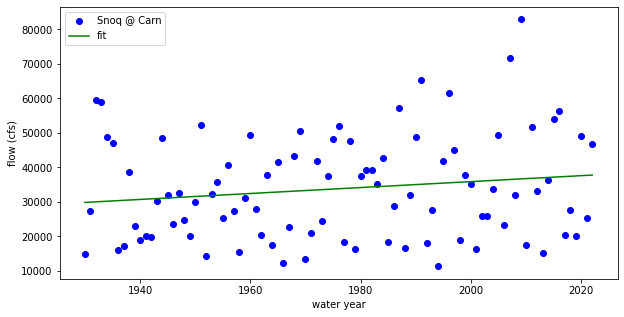

slope  86.1567843394706 (861.57 every 10 years)
p_value  0.13973888975507928
r_value  0.1543014709144523
std_err  57.831722944322465
conv_interval 96.23198697935258 (+/-962.32 over 10 years - 90% conf, -100.75 - 1823.89)
Mann-Kendall test: 90%
  slope: no trend
      h: No monottonic trend
      p: 0.18000063360677432
      z: 1.340753082820409


In [7]:
x_data = df['water_year']
y_data = df['peak_va']

plot_data(x_data, y_data, 'water year', 'flow (cfs)', 'Snoq @ Carn')

### Gage Flow (1934 on)
From 1934 through 2016.

/var/folders/7d/mngrr_516hd2614y74lctr_80000gn/T/ipykernel_12145/305832758.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_data, func(x_data, slope, intercept), 'r-', label='fit',color='green')


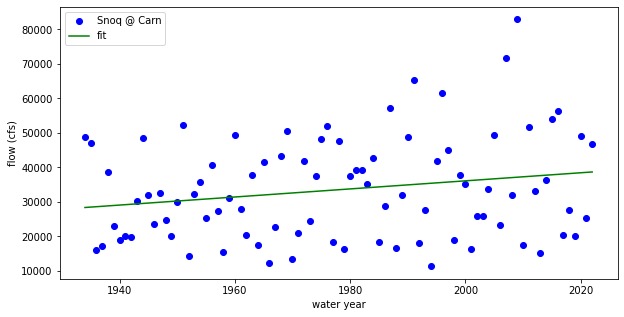

slope  117.03779366700714 (1170.38 every 10 years)
p_value  0.054254315885387816
r_value  0.20475572628436994
std_err  59.98328114793195
conv_interval 99.81217983015875 (+/-998.12 over 10 years - 90% conf, 172.2600000000001 - 2168.5)
Mann-Kendall test: 90%
  slope: no trend
      h: No monottonic trend
      p: 0.10159221561294296
      z: 1.637183107359133


In [8]:
x_data = df[df['water_year']>=1934]['water_year']
y_data = df[df['water_year']>=1934]['peak_va']

plot_data(x_data, y_data, 'water year', 'flow (cfs)', 'Snoq @ Carn')

### Max Gage Flow (2 year buckets)

/var/folders/7d/mngrr_516hd2614y74lctr_80000gn/T/ipykernel_12145/305832758.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_data, func(x_data, slope, intercept), 'r-', label='fit',color='green')


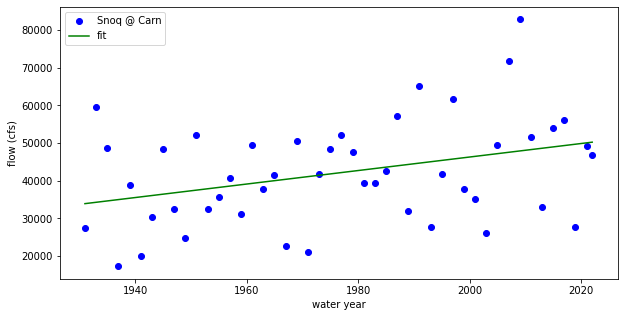

slope  179.61396099771449 (1796.14 every 10 years)
p_value  0.014827654347718823
r_value  0.3533744932417983
std_err  70.88168683297029
conv_interval 117.94712689006255 (+/-1179.47 over 10 years - 90% conf, 616.6700000000001 - 2975.61)
Mann-Kendall test: 90%
  slope: increasing
      h: Monotonic trend is present
      p: 0.023535644376987408
      z: 2.264625929048882
Mann-Kendall test: 95%
  slope: increasing
      h: Monotonic trend is present
      p: 0.023535644376987408
      z: 2.264625929048882
Mann-Kendall test: 99%
  slope: no trend
      h: No monottonic trend
      p: 0.023535644376987408
      z: 2.264625929048882


In [9]:
df['two_year'] = (df['water_year']/2).apply(int)*2
max = df.groupby('two_year').max()
x_data = max['water_year']
y_data = max['peak_va']

plot_data(x_data, y_data, 'water year', 'flow (cfs)', 'Snoq @ Carn')

## Data Table

In [10]:
df

,water_year,peak_va,gage_ht,two_year
0,1930,14800.0,7.62,1930
1,1931,27400.0,10.51,1930
2,1932,59500.0,NaN,1932
3,1933,59000.0,NaN,1932
4,1934,48700.0,15.83,1934
...,...,...,...,...
88,2018,27800.0,56.08,2018
89,2019,20100.0,53.91,2018
90,2020,49200.0,58.72,2020
91,2021,25200.0,55.26,2020
